In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from keras.optimizers import SGD, Adam, RMSprop, Adamax, Adadelta
from keras.models import Model, load_model
from keras import Input
from keras.layers import Dense, Dropout, Multiply, concatenate, LeakyReLU
from matplotlib import pyplot as plt
import keras.backend as K
from sklearn.preprocessing import StandardScaler
from keras.utils.vis_utils import plot_model
from keras.callbacks import Callback
from sklearn.preprocessing import quantile_transform
import psycopg2
import missingno as msno

Using TensorFlow backend.


In [3]:
def custom_loss(y_true,y_pred):
        # M * R * G
        # (1-w *R) * R * G
        weights = y_pred[:,0]
        g_i = y_pred[:,1]
        excess_returns = y_true
        M = 1-K.sum(weights * excess_returns)
        custom_loss_value = K.mean((M * excess_returns * g_i)**2)
        return custom_loss_value

In [128]:
#reload=load_model('Networks\prototype.h5')
reload = load_model('Networks\prototype_03.h5', custom_objects={'custom_loss': custom_loss} )
Loss=[]
Return_List=[]
Return_List_weight_adjusted = []
Return_List_BH=[]

In [129]:
# database cols: needed only once

conn = psycopg2.connect("dbname=Kelly_2017_2020 user=postgres password=password")
cur = conn.cursor()

cur.execute("SELECT column_name from information_schema.columns WHERE (table_name = 'data');")
column_names = cur.fetchall()
print("got column_names")

cur.execute("SELECT column_name from information_schema.columns WHERE (table_name = 'macro');")
macro_column_names = cur.fetchall()
print("got macro_column_names")

cur.execute("SELECT * From macro;")
macro_data = cur.fetchall()
macro_data = pd.DataFrame(macro_data, columns=pd.DataFrame(macro_column_names)[0])

print("got macro_data")

conn.commit()
cur.close()
conn.close()

got column_names
got macro_column_names
got macro_data


In [130]:
date_list = macro_data["eom"]
variables=pd.read_excel("C:\\Users\\Vincent\\01 Python_Working_Directory\\Master\\Test\\Data\\Data Fabio\\Output\\variables_small.xlsx",\
                  sheet_name = "variables", usecols = "A:B")
identifiers=variables[(variables["TYPE"]=="identifier") | (variables["TYPE"]=="observation identifier")]
identifiers=list(identifiers["VARIABLE"])
identifiers.remove("eom")
delete_cols = pd.read_csv("Networks\delete_cols.csv")

In [132]:
for date in date_list:

    # import Dataset
    # pull based on date
    conn = psycopg2.connect("dbname=Kelly_2017_2020 user=postgres password=password")
    cur = conn.cursor()
    cur.execute("SELECT * FROM data WHERE eom like '"+str(date)+"';")
    eval_batch = cur.fetchall()
    conn.commit()
    cur.close()
    conn.close()
    print("imported:"+ str(date))

    eval_batch = pd.DataFrame(eval_batch, columns = pd.DataFrame(column_names)[0])
    eval_batch.replace("EMPTY", np.nan, inplace = True)
    eval_batch.drop(columns=identifiers, inplace = True)
    eval_batch = eval_batch[False == eval_batch["ret_exc_lead1m"].isnull()]
    
    eval_batch = pd.merge(eval_batch,macro_data, on ="eom" )
    eval_batch.drop(columns=["eom"], inplace = True)
    eval_batch.drop(columns=delete_cols["0"], inplace = True)
    eval_batch=eval_batch.loc[False==eval_batch.isna().any(axis=1),:]
    #eval_batch.fillna(eval_batch.median(), inplace=True)
    
    X_eval_batch=quantile_transform(np.array(eval_batch.drop(columns=['ret_exc_lead1m'])), n_quantiles=1000)
    X_eval_batch=pd.DataFrame(X_eval_batch)
    Y_eval_batch = eval_batch["ret_exc_lead1m"].astype(float)
    print("finished preprocessing")
    
    w=reload.predict(X_eval_batch)
    Loss.append(np.mean((1-sum(w[:,0]*Y_eval_batch))*Y_eval_batch))
    Return_List.append(sum(w[:,0]*Y_eval_batch))
    Return_List_weight_adjusted.append(sum((w[:,0]/np.sum(w[:,0]))*Y_eval_batch))
    Return_List_BH.append(Y_eval_batch.mean())
    print("predicted and saved results")

imported:21945.0


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


finished preprocessing
predicted and saved results
imported:21914.0


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


finished preprocessing
predicted and saved results
imported:21974.0


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


finished preprocessing
predicted and saved results
imported:22005.0


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


finished preprocessing
predicted and saved results
imported:22035.0


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


finished preprocessing
predicted and saved results
imported:22066.0


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


finished preprocessing
predicted and saved results
imported:22096.0


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


finished preprocessing
predicted and saved results
imported:22127.0


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


finished preprocessing
predicted and saved results
imported:22158.0


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


finished preprocessing
predicted and saved results
imported:22188.0


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


finished preprocessing
predicted and saved results
imported:22219.0


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


finished preprocessing
predicted and saved results
imported:22249.0


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


finished preprocessing
predicted and saved results
imported:22280.0


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)
C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (295). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


finished preprocessing
predicted and saved results
imported:20909.0


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


finished preprocessing
predicted and saved results
imported:20939.0


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


finished preprocessing
predicted and saved results


(array([ 878., 1322.,  456.,  243.,  147.,   77.,   49.,   24.,   11.,
           5.]),
 array([0.00080768, 0.00082106, 0.00083444, 0.00084781, 0.00086119,
        0.00087457, 0.00088794, 0.00090132, 0.0009147 , 0.00092807,
        0.00094145], dtype=float32),
 <a list of 10 Patch objects>)

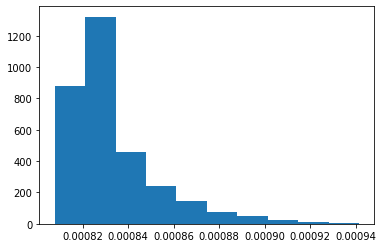

In [133]:
plt.hist(w[:,0])

In [ ]:
Loss
Return_List
Return_List_weight_adjusted
Return_List_BH

In [134]:
plotlist=[]
for i in range(1,16):
    plotlist.append(i)
plotlist

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [135]:
len(Return_List_weight_adjusted)

15

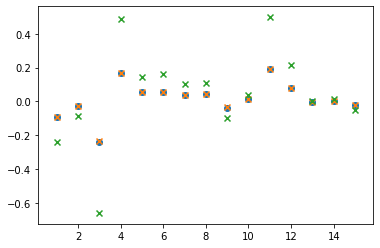

In [136]:
# Return of Model vs buy and hold strategy
plt.scatter(plotlist,Return_List_weight_adjusted, marker = "o") 
plt.scatter(plotlist,Return_List_BH, marker = "x")
plt.scatter(plotlist,Return_List, marker = "x")

In [150]:
SR_NN = np.array(Return_List).mean()/np.array(Return_List).std()
SR_BH = np.array(Return_List_BH).mean()/np.array(Return_List_BH).std()

In [151]:
SR_BH

0.46005321803587007

In [152]:
# unfortunately sharpe ratio of NN is not improved against the Buy and Hold strategy
SR_NN

0.46278696290503774